# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math 
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep ='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


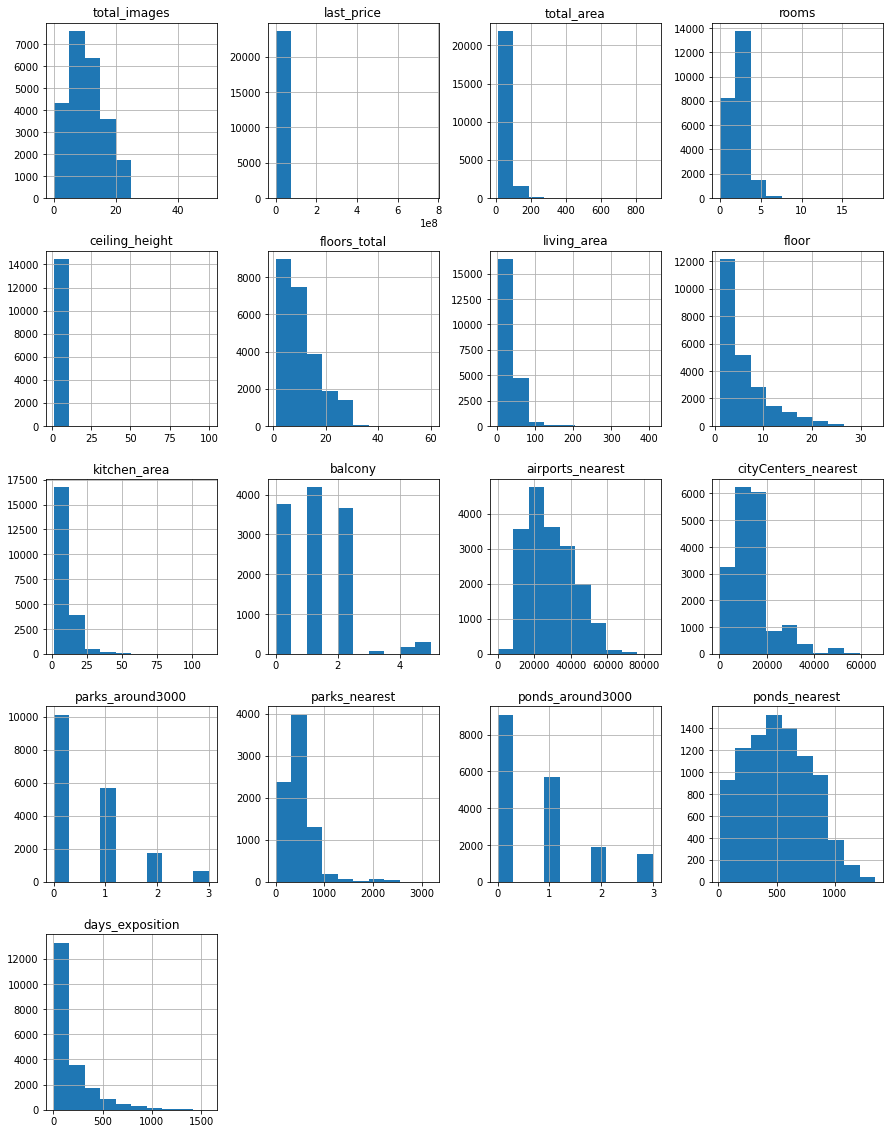

In [3]:
data.info()
display(data.head())
data.hist(figsize=(15, 20));

#### Промежуточные выводы
Файл прочтен успешно. В столбцах с данными о балконах,апартаментах, наличии прудов и парков много пропусков.Тип в столбцах о колличестве этажей и балконов нужно заменить на целочисленный тип. В столбце о дате публикации нужно будет форматировать строку в дату.

Наблюдаются выбросы на графиках о длительности размещения объявления, жилой площади и площади кухни.

### Предобработка данных

Считаем и удаляем дубликаты:

In [4]:
data.duplicated().sum()
data = data.drop_duplicates().reset_index(drop=True)

Считаем и удаляем пропуски:

In [5]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [6]:
data = data.dropna(subset =['floors_total','locality_name']).reset_index(drop=True)


В столбцах *locality_name* и *floors_total* строки с пропусками будут удалены так как их кол-во не значительно и востановить эти пропуски не получится, однако этажность и населенный пункт сильно влияют на стоимость жилья. Поэтому удаление этих строк не повлияет на качество вывода

In [7]:
data.loc[data['ceiling_height'] > 19 ,'ceiling_height'] = data.loc[data['ceiling_height'] > 19 ,'ceiling_height'] = data['ceiling_height'] / 10

In [8]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)
#data['kitchen_area'] = data['kitchen_area'].fillna(0)

Значения в высоты потолков больше 14м были уменьшены. Пропущенные данные по кол-ву балконов заменены на 0, так как скорей всего балкона в данной квартире нети люди ничего не указали. Также косательно статуса аппартамента, было всего 50 аппартаментов из указаных, значит люди скорей всего просто не указвали статус.

In [9]:
to_integers = ['floors_total','last_price','balcony','parks_around3000','ponds_around3000','days_exposition']
for i in to_integers:
    #data[i] = pd.to_numeric(data[i],downcast='integer')
    data[i] = data[i].astype('int64', errors='ignore')

Поменял тип данных на int64, так как это значения могут быть только целые.Изменил в столбцах:'floors_total','last_price','balcony'

Удаляем неявные дубликаты:

In [10]:
def local_type(row):
    if 'поселок' in row['locality_name'] and 'коттедж' not in row['locality_name']:
        if  len(row['locality_name'].split()) >= 3 and 'тип' not in row['locality_name'] and 'город' not in row['locality_name']:
            a = " ".join(row['locality_name'].split()[-1])
            return 'поселок ' + a.replace(" ", "")
        else:
            a = " ".join(row['locality_name'].split()[-1])
            return 'поселок '+a.replace(" ", "")
    elif 'поселок' in row['locality_name'] and 'коттедж' in row['locality_name']:
          if  len(row['locality_name'].split()) > 3:
            return 'коттеджный поселок '+ " ".join(row['locality_name'].split()[-2:])
          else:
            return 'коттеджный поселок '+str(row['locality_name'].split()[-1])
        
    if 'село' in row['locality_name']:
        if  len(row['locality_name'].split()) > 2:
            return 'село '+" ".join(row['locality_name'].split()[-2:])
        else:
            return 'село '+str(row['locality_name'].split()[-1])
        
    if 'товарищество' in row['locality_name']:
        if  len(row['locality_name'].split()) >= 3 and 'тип' not in row['locality_name'] and 'город' not in row['locality_name']:
            a = " ".join(row['locality_name'].split()[-1])
            return 'товарищество ' + a.replace(" ", "")
        else:
            a = " ".join(row['locality_name'].split()[-1])
            return 'товарищество '+a.replace(" ", "")
    
    if 'деревня' in row['locality_name']:
        if  len(row['locality_name'].split()) >= 3:
            return 'деревня '+ " ".join(row['locality_name'].split()[-2:])
        else:
            return 'деревня '+str(row['locality_name'].split()[-1])
    
    if 'коттедж' in row['locality_name']:
        if  len(row['locality_name'].split()) >= 3:
            return 'коттеджный поселок '+ " ".join(row['locality_name'].split()[-2:])
        else:
            return 'коттеджный поселок '+str(row['locality_name'].split()[-1])
    
    else:
        return row['locality_name']

In [11]:
def del_letter(row):
    word = ''
    for i in row['locality_name']:
        if i == 'ё':
            word += 'е'
            continue
        word += i    
    row['locality_name'] = word    
    return row['locality_name'] 
data['locality_name'] = data.apply(del_letter, axis = 1)
data['new_toponims'] = data.apply(local_type,axis = 1)


In [12]:
uniq_local = data['new_toponims'].unique()
list_of_types = []
for local in uniq_local:
    if len(local.split()) > 1:
        list_of_types.append(local.split()[-1])
df = pd.DataFrame(list_of_types, columns=['a'])        
list_of_towns = data['new_toponims'].value_counts().sort_values() 
list_of_towns.rename_axis('index').reset_index().sort_values(by ='index') 
df = df.value_counts()
df = df.rename_axis('town').reset_index()
df.columns = ['town','s']
df = df.query('s > 1')

полные названия дуликатов:

In [13]:
uniq_local = data['locality_name'].unique()
list_of_types = []
for local in uniq_local:
    if len(local.split()) > 1:
        list_of_types.append(local.split()[-1])
    else:
        local
df = pd.DataFrame(list_of_types, 
    columns=['a'])        
list_of_towns = data['locality_name'].value_counts().sort_values() 
list_of_towns.rename_axis('index').reset_index().sort_values(by ='index') 
df = df.value_counts()
df = df.rename_axis('town').reset_index()
df.columns = ['town','s']
df = df.query('s > 1')
def fuck(row):
    for d in df['town']:
        if d in str(row['locality_name']):
            
            return row['locality_name']
uniq_local = pd.DataFrame(uniq_local, 
    columns=['locality_name'])
final = uniq_local.apply(fuck, axis=1).dropna()
final.sort_values()

108                                         Новая Ладога
52                                          Сосновый Бор
89                       городской поселок Большая Ижора
93                         городской поселок Лесогорский
120                                городской поселок Мга
155                              городской поселок Назия
90                             городской поселок Павлово
223                             городской поселок Рощино
262                          городской поселок Советский
106                        городской поселок Федоровское
118                                     деревня Бегуницы
100                              деревня Большие Колпаны
258                                          деревня Бор
328                               деревня Борисова Грива
166                                    деревня Гарболово
269                                     деревня Зимитицы
138                                     деревня Калитино
321                            

удаление слишком низких потолков и замена NAN на медианную высоту:

In [14]:
data['ceiling_height'] = data.loc[data['ceiling_height']>2,'ceiling_height']
data['ceiling_height'] = data.loc[data['ceiling_height']<8,'ceiling_height']
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Удаление выбросов в столбцах:Стоимость недвижиости,кол-ва комнат,общей площади, время продажи 

,price_mln,rooms,total_area
count,23565.000000,23565.000000,23565.000000
mean,6.540058,2.070656,60.322824
std,10.910935,1.078591,35.657060
min,0.012190,0.000000,12.000000
25%,3.400000,1.000000,40.000000
50%,4.646000,2.000000,52.000000
75%,6.790000,3.000000,69.700000
max,763.000000,19.000000,900.000000


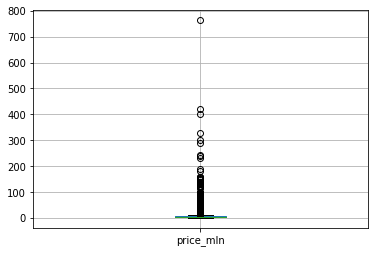

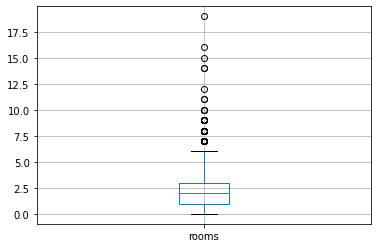

<AxesSubplot:>

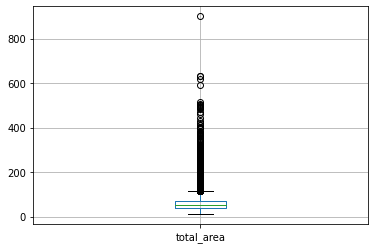

In [15]:
#добавим столбец цена в миллионах чтобы было проще оценивать значения
data['price_mln'] = data['last_price'] / 1000000
display(data[['price_mln', 'rooms','total_area']].describe())
data.boxplot(column='price_mln')
plt.show()
data.boxplot(column='rooms')
plt.show()
data.boxplot(column='total_area')

Удаляются выбросы по:
цене за пределеами интервала 600 тыс руб - 100млн
кол-ву комнат больше 7и и больше 0
общей площади меньше 200кв м и больше 20 кв. м 
удалены объявления страше 300 дней и меньше 2 дней.

Возможно маленькая площадь так как продают комнату.
Указывают 0 комнат так как продают студию
длинный хвост в цене говорит об отдельном виде объектов: Элитная недвижимость.

In [18]:

data['last_price'] = data.loc[(data['last_price']>600000) & (data['last_price'] <100000000),'last_price']
data['rooms'] = data.loc[(data['rooms']>0) & (data['rooms']<7),'rooms']
data['total_area'] = data.loc[(data['total_area']>20)  & (data['total_area']<200),'total_area']
data['days_exposition'] = data.loc[(data['days_exposition']>1)  & (data['days_exposition']<300),'days_exposition']

In [19]:
d = pd.read_csv('/datasets/real_estate_data.csv',sep ='\t')

data.shape[0] / d.shape[0]

0.994345752985358

#### Промежуточный вывод
Были удалены строки без информации о населеном пункте и этажности. Также устранены аномалии в высоте полков общей площади, кол-ве комнат и цене объекта,сменен тип данных у значений которые могут быть только целыми.Удалены дубликаты, неявные дубликаты устранны добавлением нового столбца.

### Посчитайте и добавьте в таблицу новые столбцы

In [20]:
#цена одного квадратного метра;
data['total_area'].dropna()
data['meter_price'] = data['last_price'] / data['total_area']

In [21]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
#месяц публикации объявления;
#год публикации объявления;
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format = '%Y-%m-%dT%H:%M:%S')
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round()

#расстояние до аэропорта в километрах (переведите из м в км и округлите до целых значений).
data['airports_nearest_km'] = data['airports_nearest'] / 1000
data['airports_nearest_km'] = data['airports_nearest'].round()

In [22]:
def flor(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'

In [23]:
#тип этажа квартиры (значения — «‎первый», «последний», «другой»);
data['floor_type'] = data.apply(flor,axis = 1)

In [24]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_toponims,price_mln,meter_price,day_exposition,month_exposition,year_exposition,cityCenters_nearest_km,airports_nearest_km,floor_type
0,20,13000000.0,108.00,2019-03-07,3.0,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург,13.000,120370.370370,3,3,2019,16.0,18863.0,другой
1,7,3350000.0,40.40,2018-12-04,1.0,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,поселок Шушары,3.350,82920.792079,1,12,2018,19.0,12817.0,первый
2,10,5196000.0,56.00,2015-08-20,2.0,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,NaN,Санкт-Петербург,5.196,92785.714286,3,8,2015,14.0,21741.0,другой
3,0,64900000.0,159.00,2015-07-24,3.0,2.65,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,NaN,Санкт-Петербург,64.900,408176.100629,4,7,2015,7.0,28098.0,другой
4,2,10000000.0,100.00,2018-06-19,2.0,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург,10.000,100000.000000,1,6,2018,8.0,31856.0,другой
5,10,2890000.0,30.40,2018-09-10,1.0,2.65,12,14.40,5,False,False,False,9.10,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,поселок Янино-1,2.890,95065.789474,0,9,2018,NaN,NaN,другой
6,6,3700000.0,37.30,2017-11-02,1.0,2.65,26,10.60,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,поселок Парголово,3.700,99195.710456,3,11,2017,19.0,52996.0,другой
7,5,7915000.0,71.60,2019-04-18,2.0,2.65,24,NaN,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,7.915,110544.692737,3,4,2019,12.0,23982.0,другой
8,20,2900000.0,33.16,2018-05-23,1.0,2.65,27,15.43,26,False,False,False,8.81,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,поселок Мурино,2.900,87454.764777,2,5,2018,NaN,NaN,другой
9,18,5400000.0,61.00,2017-02-26,3.0,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,Санкт-Петербург,5.400,88524.590164,6,2,2017,15.0,50898.0,другой


#### Промежуточные выводы
Добалены стлобцы успешно.

### Проведите исследовательский анализ данных

 Изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления

count    23300.000000
mean        58.187836
std         26.422135
min         20.100000
25%         40.000000
50%         51.900000
75%         68.857500
max        199.200000
Name: total_area, dtype: float64


825

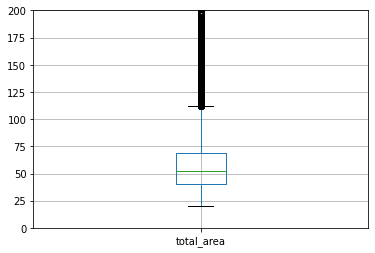

In [25]:
#data.plot(kind='hist',y = 'total_area',range=(0,200),bins = 100, grid = True)
plt.ylim(0, 200)
data.boxplot(column='total_area')
print(data['total_area'].describe())

data.loc[data['total_area'] > 120,'total_area'].count()

Большую часть объявлений составляют помещения до 60 кв.м. Также наблюдается длинный хвост в 1000 шт из значений выше 120 кв.м, что указвает на преобладаение объявлений по продаже  квартир малой квадратуры над продажами частных домов или квартир с большой площадью.

count    21700.000000
mean        34.454822
std         22.045359
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64


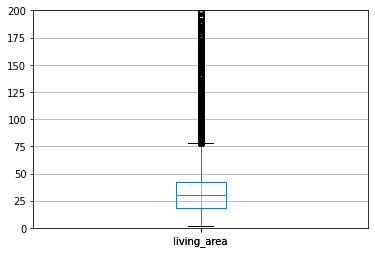

In [26]:
data.boxplot(column='living_area')
plt.ylim(0, 200)
data.boxplot(column='living_area')
print(data['living_area'].describe())


Значения жилой площади в объявления скоцентрированы в диапозоне 18-42 кв.м. Также наблюдается сокращение стандартного отклонения. 

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


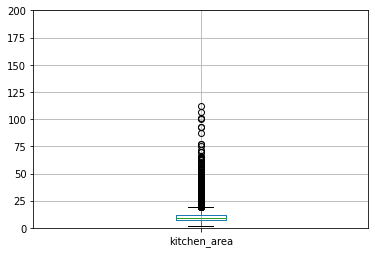

In [27]:
plt.ylim(0, 200)
data.boxplot(column='kitchen_area')
print(data['kitchen_area'].describe())

львиная доля квартир имеет схожую площадь кухонь, однако также виден длинный хвост с объявлениями о продаже недвижимости с большими кухнями

count    23565.000000
mean         2.697208
std          0.220861
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64


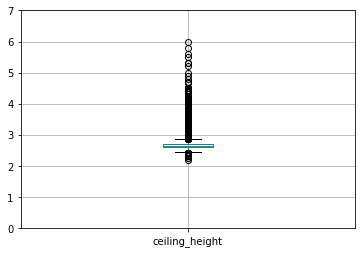

In [28]:
plt.ylim(0, 7)
data.boxplot(column='ceiling_height')
print(data['ceiling_height'].describe())

Высота потолков в квартирах практически одинаковая. Сказывается массовая стандартизированная застройка по гостам высоты потолков.

count    23565.000000
mean         5.878124
std          4.871485
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


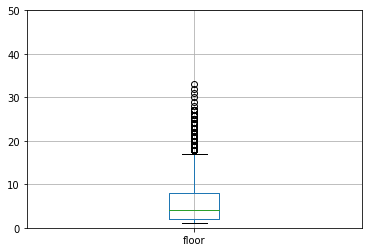

In [29]:
plt.ylim(0, 50)
data.boxplot(column='floor')
print(data['floor'].describe())

Большая часть объявления о продаже недвижимости не выше 9 этажа.

<AxesSubplot:>

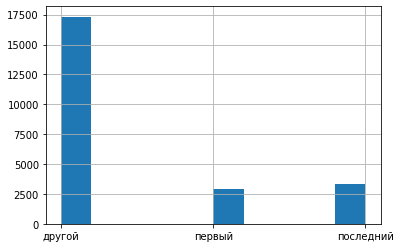

In [30]:
data['floor_type'].hist()

объявления о продаже квартир на первом или последнем этаже относительно равны, с небольшым преобладанием квартир на последних этажах.

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


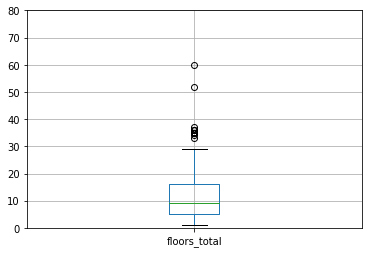

In [31]:
plt.ylim(0, 80)
data.boxplot(column='floors_total')
print(data['floors_total'].describe())

Наиболее распространненая высота застройки это 16 этажей, однако есть единичные случаи высотного строительства.

count    18064.000000
mean     14192.656056
std       8613.348153
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


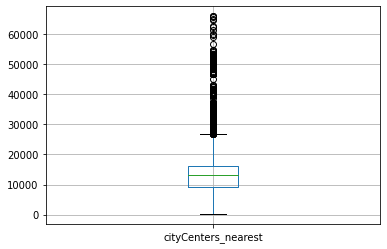

In [32]:
data.boxplot(column='cityCenters_nearest')
print(data['cityCenters_nearest'].describe())

Наибольшее колличество квартир продается в радиусе 16 км от центра города.

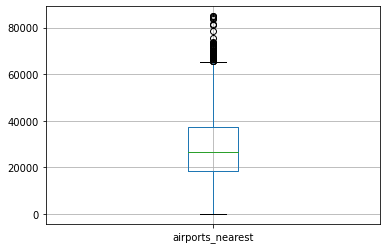

count    18041.000000
mean     28797.082701
std      12632.499735
min          0.000000
25%      18565.000000
50%      26757.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64


In [33]:

data.boxplot(column='airports_nearest')
plt.show()
print(data['airports_nearest'].describe())

Большая часть квартир находится в удалении от 19 до 37 км от аэропорта. 

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


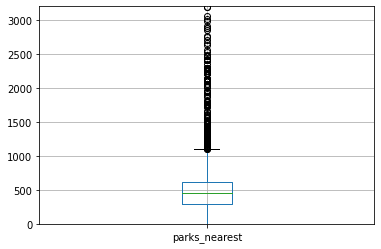

In [34]:
plt.ylim(0, 3200)
data.boxplot(column='parks_nearest')
print(data['parks_nearest'].describe())

В большинстве объявлений до парка будет от 300 до 600 метров.

count    23565.000000
mean         2.567367
std          1.788279
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_exposition, dtype: float64


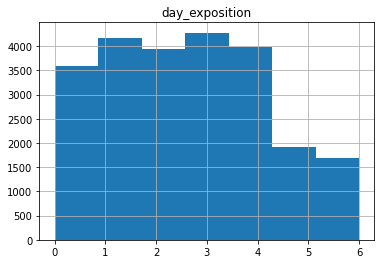

In [35]:
#plt.ylim(0, 200)
data.hist(column='day_exposition', bins =7 )
print(data['day_exposition'].describe())

Чаще объявления публикуют с понедельника по пятницу, в выходные это происходит в два раза реже.Пики наблюдаются во вторник и четверг.

                  month_exposition
month_exposition                  
1                             1487
2                             2636
3                             2575
4                             2356
5                             1261
6                             1747
7                             1686
8                             1739
9                             1972
10                            2108
11                            2360
12                            1638


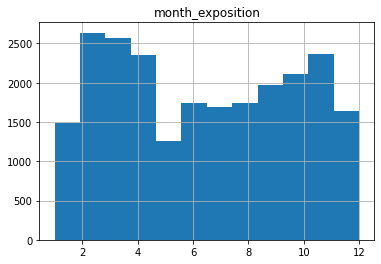

In [36]:
#plt.ylim(0, 200)
data.hist(column='month_exposition',bins = 12)
print(data.groupby('month_exposition').agg({'month_exposition':'count'}))

Весной и осенью наблюдается повышение кол-ва публикаций объявлений. Пик приходится на Февраль и Март.Минимумы находятся в январе, июле и декабре.

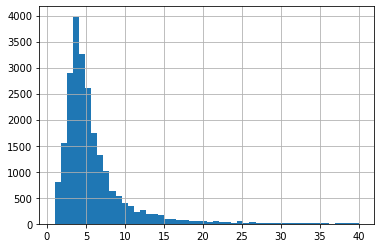

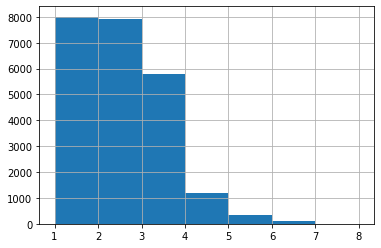

count    23565.000000
mean         6.540058
std         10.910935
min          0.012190
25%          3.400000
50%          4.646000
75%          6.790000
max        763.000000
Name: price_mln, dtype: float64

In [37]:
data['price_mln'].hist(range=(1,40), bins = 50)
plt.show()
data['rooms'].hist(range=(1,8), bins = 7)
plt.show()
data['price_mln'].describe()

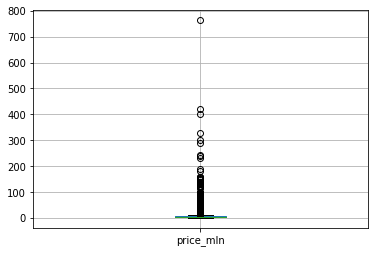

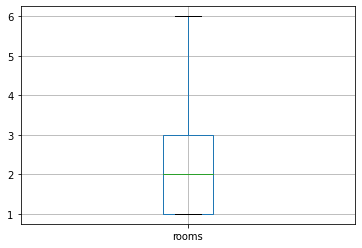

In [38]:
data.boxplot(column='price_mln')
plt.show()
data.boxplot(column='rooms')
plt.show()

Как быстро продавались квартиры:

count    16489.000000
mean        92.774577
std         74.701688
min          2.000000
25%         35.000000
50%         68.000000
75%        138.000000
max        299.000000
Name: days_exposition, dtype: float64


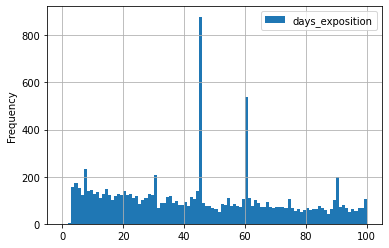

<AxesSubplot:ylabel='Frequency'>

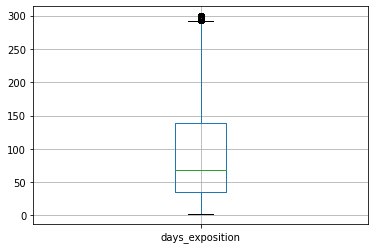

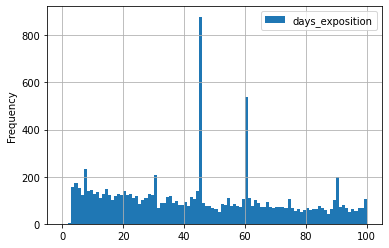

In [39]:
#data['days_exposition'] =data['days_exposition'] > 1000
data.plot(kind='hist', y='days_exposition',grid = True,bins = 100, range = (0, 100))
print(data['days_exposition'].describe())
plt.show()
data.boxplot(column='days_exposition')
data.plot(kind='hist', y='days_exposition',grid = True,bins = 100, range = (0, 100))
#data.pivot_table(index='days_exposition', values='price_mln').hist(range = (30, 70),bins = 100)

Обычное объявление продается в районе 95 дней. Слишком быстрая продажа это срок до 9 дней, слишком долгая продажа считается более 500 дней.Также видны пики в районе 45 и 60 дней, скорей всего это связанно со сроком одобрения ипотеки, который как раз составляет 2-3 месяца.

              floors_total  kitchen_area  last_price  living_area     rooms  \
floors_total      1.000000      0.236906    0.240226    -0.108803 -0.148762   
kitchen_area      0.236906      1.000000    0.548883     0.253187  0.033042   
last_price        0.240226      0.548883    1.000000     0.592242  0.239058   
living_area      -0.108803      0.253187    0.592242     1.000000  0.727871   
rooms            -0.148762      0.033042    0.239058     0.727871  1.000000   
total_area       -0.031455      0.532744    0.542588     0.839468  0.742826   

              total_area  
floors_total   -0.031455  
kitchen_area    0.532744  
last_price      0.542588  
living_area     0.839468  
rooms           0.742826  
total_area      1.000000  


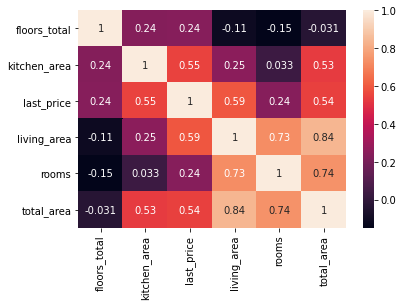

<AxesSubplot:xlabel='year_exposition'>

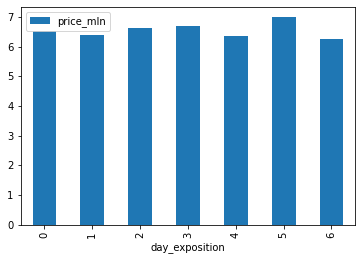

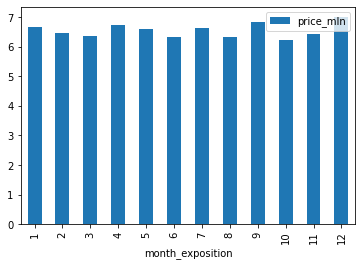

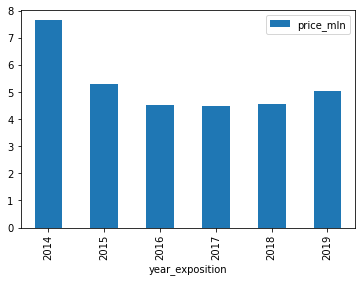

In [40]:
#таблица корреляций
real_estat_stat = \
data.pivot_table(index = 'new_toponims',\
                 values =['last_price','total_area','living_area','kitchen_area','rooms','floors_total'])
flr_type = data.pivot_table(index = 'floor_type', values ='last_price')
print(real_estat_stat.corr()) 
#pd.plotting.scatter_matrix(real_estat_stat, figsize = (9,9))
sb.heatmap(real_estat_stat.corr(), annot=True)
plt.show()
data.pivot_table(index = 'day_exposition', values ='price_mln').plot(kind='bar')
data.pivot_table(index = 'month_exposition', values ='price_mln').plot(kind='bar')
data.pivot_table(index = 'year_exposition', values ='price_mln', aggfunc='median').plot(kind='bar')

Данные были сгрупированны по населенным пунктам. Наблюдается корреляция с площедью кухни,общей площадью а также с жилой площадью. Время публикации объявления не оказали существенного влияния на стоимость квартиры. Так же наблюдается сильная связь этажа и цены. Квартиры на первых этажах на 30% дешевле квартир выше.

Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.И выделение населённых пунктов с самой высокой и низкой стоимостью квадратного метра.

In [41]:

price_sq_met = data.pivot_table(index = 'new_toponims', values = 'meter_price', aggfunc=['count','mean'])
price_sq_met.columns = ['offers','mean_price']
sub_data = price_sq_met.nlargest(10,'offers')
hieghest_price = price_sq_met.nlargest(1,'mean_price')
lowest_price = price_sq_met.sort_values('mean_price').head(1)
sub_data

,offers,mean_price
new_toponims,,
Санкт-Петербург,15405,113156.945033
поселок Мурино,551,85626.174066
поселок Шушары,438,78529.235071
Всеволожск,397,68682.570898
Пушкин,363,103077.242205
Колпино,337,75333.295801
поселок Парголово,326,90332.263023
Гатчина,307,68746.146763
деревня Кудрово,298,92481.848071


Самый дорогой квадратный метр в городе Зеленогорск, самая дешевая недвижимость в деревне Старополье. 
Наибольшее число объявлений приходится на Питер и его окресности

<AxesSubplot:xlabel='cityCenters_nearest_km'>

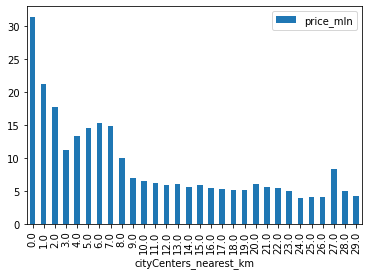

In [42]:
# Считаем среднюю цену для каждого километра в питере
sub_data_spb = data.loc[data['locality_name'] == 'Санкт-Петербург'].pivot_table(index='cityCenters_nearest_km', values='price_mln')
sub_data_spb.plot(kind='bar')


На графике ярко выражена зависимость цены от удаления от центра. Однако стоит обратить внимание, что есть два пика: в самом центре и небольшом удалении от него. Начиная с 7 км цена на недвижимость в питере выходит на плато. Из чего можно сделать вывод.Наиболее популярные районы это центр и небольшое удаление от него(4 - 7 км). 

#### Промежуточный вывод


Самым распространным объевлением является продажа квартиры в питере в шестнадести этажке до 9 этажа.
Типичный объект недвижимости представляет собой  60кв. м, высота потолка 2.6м, жилая от 20-40 кв.м, кухня площадью 9 кв.м.
В радиаусе 600 метров будет находится парк, в 30 км аэропорт.
Продажа занимает около 3 месяцев, пик продаж осенью и весной. Виден спад средней стоимость объекта и медианной стоимости после 2014 года, причной может служить известное событие марта 2014. также наблюдается плавное возвразение от года к году средних  цен к до кризисному уровню.

### Общий вывод

Данные для анализа содержали много пропусков, данные о парках и прудах видимо игнорировались составителем объявления. Как и является ли недвижимость аппартаментом. Данные которые не указаны пользователем должны быть обязательными перед публикацией и либо быть выбраны из списка готовых значений, либо подставляться автоматически.

Тоже касается неявных дубликатов, человек должен выбирать населенный пункт из списка или на карте.Нужно ввести ограничение на величину значения для высоты потолков, чтобы не было 20 метровых или 1 метровых потолков.

По данным представленным в таблице можно сделать вывод, что больше всего общая площадь и площадь кухни коррелирует с ценой. Как и удаление от центра города. В Питере есть 3 группы радиуса цены. Квартиры в центре(0км-3км), среднем удалении (4км-7км), остальные(от 9км). Медианная цена объекта 4,6 млн рублей за весь период наблюдений. Видны пики в продажах на 45 и 60 дней, судя по всему это связано со сроками одобрения ипотеки.

Рынок недвижимости после 2014 года начал свое востановление и наблюдается рост средних цен на объект.В дальнейшем нужно провести сравнение общих показателей по году и по населенному пункту для постраения тепловой карты изменения средних показателей цен и характеристик недвижимости.

Самая дорогая недвижимость в Зеленграде.
Самая деешвая в деревне Старополье.

Краткий список действий:
Были удалены выбросы в кол-ве комнат,общей площади,цене объекта, высоте потолков.
Заменены пропуски и удалены пропуски.
Анализированы зависимости разлиных факторов относильно цены объекта.